# Depth images processing

In [1]:
%matplotlib inline
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import math

In [396]:
def getCropPoints(image):
    imageHSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    maskPoints = imageHSV[:,:,2]>200
    maskPoints *= imageHSV[:,:,0]>160
    maskPoints *= imageHSV[:,:,0]<170
    kernel = np.ones((12,12),np.uint8)
    maskPoints = cv2.morphologyEx(np.uint8(maskPoints), cv2.MORPH_OPEN, kernel)
    maskPoints = cv2.morphologyEx(np.uint8(maskPoints), cv2.MORPH_OPEN, kernel)
    plt.imshow(maskPoints)
    plt.show()
    rows = np.any(maskPoints, axis=1)
    cols = np.any(maskPoints, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return(rmin-40,rmax+40,cmin-40,cmax+40)
def cropImage(image,xMin=730,xMax=1200,yMin=280, yMax=730):
    return image[yMin:yMax,xMin:xMax]

def getHeightFromImage(depthImage,minValue, maxValue):
    heightData = np.zeros(depthImage.shape[0:2])
    heightData[:,:] = minValue + depthImage[:,:]/255*(maxValue-minValue)
    return heightData

def imageFromHeight(heightData, minValue, maxValue):
    depthImage = np.zeros(heightData.shape)
    depthImage[:,:] = ((heightData[:,:]-minValue)/(maxValue-minValue))*255
    return depthImage
    
def processImages(folder, oldHeightSettings=False):
    colorPath = folder+'/depth_color.png'
    depthPath = folder+'/depth.png'
    baseDepthPath = folder+'/depth_base.png'
    color = io.imread(colorPath)
    depth = io.imread(depthPath)[:,:,0]
    baseDepthImage = io.imread(baseDepthPath)[:,:,0]
    cropPoints = getCropPoints(color)
    colorImage = cropImage(color, xMin=cropPoints[2], xMax=cropPoints[3], yMin=cropPoints[0], yMax=cropPoints[1])
    depthImage = cropImage(depth, xMin=cropPoints[2], xMax=cropPoints[3], yMin=cropPoints[0], yMax=cropPoints[1])
    baseDepthImage = cropImage(baseDepthImage, xMin=cropPoints[2], xMax=cropPoints[3], yMin=cropPoints[0], yMax=cropPoints[1])
    baseHeight = getHeightFromImage(baseDepthImage, 360, 550)
    if(oldHeightSettings):
        heightData = getHeightFromImage(depthImage, 490, 640)
        newHeight = baseHeight-heightData
        depthImage = newHeight*2
    else:
        heightData = getHeightFromImage(depthImage, 360, 550)
        newHeight = baseHeight-heightData
        depthImage = newHeight*2
    plt.imshow(colorImage)
    plt.show()
    plt.imshow(heightData,cmap='gray',vmin=0,vmax=255)
    plt.show()
    plt.imshow(depthImage,cmap='gray',vmin=0,vmax=255)
    plt.show()
    plt.imsave(folder+"/depth_processed.png",np.fliplr(depthImage),cmap='gray',vmin=0,vmax=255)
    plt.imsave(folder+"/depth_color_processed.png",np.fliplr(colorImage))
    print("Processed Folder: " + folder)
    
def processImage(imagePath,newName, oldHeightSettings=False):
    depth = io.imread(imagePath)[:,:,0]
    depthImage = cropImage(depth)
    if(oldHeightSettings):
        heightData = getHeightFromImage(depthImage, 490, 640)
        depthImage = imageFromHeight(heightData, 360, 550)
    plt.imsave(newName,depthImage,cmap='gray',vmin=0,vmax=255)
    print("Processed Image: " + imagePath + " as " + newName)

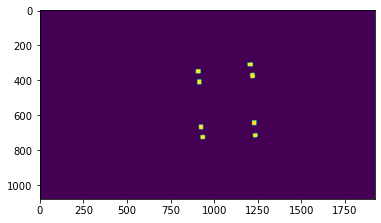

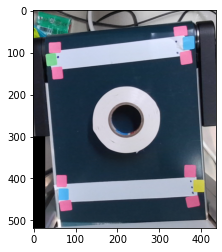

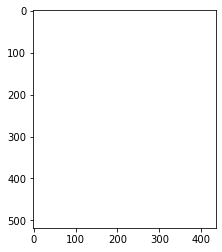

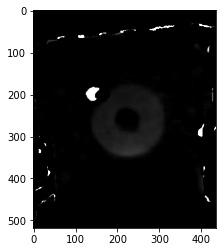

Processed Folder: ./ImatgesTest/TestA


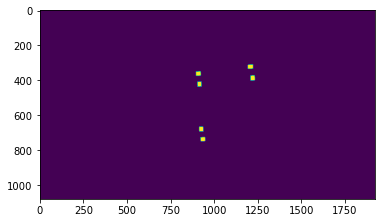

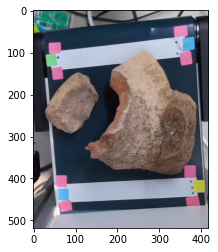

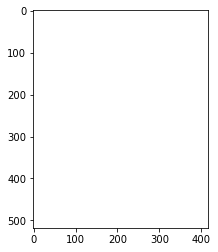

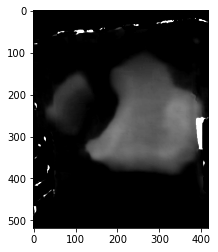

Processed Folder: ./ImatgesTest/TestB


In [397]:
baseDepthImage = cropImage(io.imread("./ImatgesTest/depth_Base2.png")[:,:,0])
#processImages("./ImatgesTest/g2_02_1A", baseDepthImage, oldHeightSettings=True)
#processImages("./ImatgesTest/g4_02_1A", baseDepthImage)
#processImages("./ImatgesTest/test")
processImages("./ImatgesTest/TestA")
processImages("./ImatgesTest/TestB")

# Image Matching

In [416]:
def DLT (right, left):
    A = []
    for i in range(len(right)):
        x1 = right[i][1]
        y1 = right[i][0]
        x2 = left[i][1]
        y2 = left[i][0]
        A.append( [x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2] )
        A.append( [0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2] )

    A = np.asarray(A)
    U, S, V = np.linalg.svd(A)
    V=np.reshape(V[-1,:],(3,3))
    return V

def transformPoint(H, point):
    newPoint=H.dot(np.array([point[1],point[0],1]))
    newPoint/=newPoint[2]
    return [newPoint[1],newPoint[0]]

def processStickers(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    kernel = np.ones((3,3),np.uint8)
    pinkMask = image[:,:,0]>160
    pinkMask *= image[:,:,0]<170
    pinkMask *= image[:,:,2]>190
    pinkMask *= image[:,:,1]<140
    pinkMask *= image[:,:,1]>70
    pinkMask = cv2.morphologyEx(np.uint8(pinkMask), cv2.MORPH_CLOSE, kernel)
    pinkMask = cv2.morphologyEx(np.uint8(pinkMask), cv2.MORPH_CLOSE, kernel)
    
    blueMask = image[:,:,0]>95
    blueMask *= image[:,:,0]<105
    blueMask *= image[:,:,2]>200
    blueMask *= image[:,:,1]<180
    blueMask *= image[:,:,1]>120
    blueMask = cv2.morphologyEx(np.uint8(blueMask), cv2.MORPH_CLOSE, kernel)
    blueMask = cv2.morphologyEx(np.uint8(blueMask), cv2.MORPH_CLOSE, kernel)
        
    greenMask = image[:,:,0]>55
    greenMask *= image[:,:,0]<75
    greenMask *= image[:,:,2]>200
    greenMask *= image[:,:,1]<110
    greenMask *= image[:,:,1]>50
    greenMask = cv2.morphologyEx(np.uint8(greenMask), cv2.MORPH_CLOSE, kernel)
    greenMask = cv2.morphologyEx(np.uint8(greenMask), cv2.MORPH_CLOSE, kernel)
    
    yellowMask = image[:,:,0]>25
    yellowMask *= image[:,:,0]<35
    yellowMask *= image[:,:,2]>140
    yellowMask *= image[:,:,1]<165
    yellowMask *= image[:,:,1]>110
    yellowMask = cv2.morphologyEx(np.uint8(yellowMask), cv2.MORPH_CLOSE, kernel)
    yellowMask = cv2.morphologyEx(np.uint8(yellowMask), cv2.MORPH_CLOSE, kernel)
    
    xMiddle = int(blueMask.shape[1]/2)
    nzbl = np.nonzero(blueMask[:,:xMiddle])
    blueLeftPos=np.mean(nzbl,axis=1)
    
    nzbr = np.nonzero(blueMask[:,xMiddle:])
    blueRightPos=np.mean(nzbr,axis=1)
    blueRightPos[1]+=xMiddle
    
    nzg = np.nonzero(greenMask)
    greenPos=np.mean(nzg,axis=1)
    
    nzy = np.nonzero(yellowMask)
    yellowPos=np.mean(nzy,axis=1)
    print("both")
    plt.imshow(pinkMask+blueMask+greenMask+yellowMask)
    plt.show()
    return [yellowPos, greenPos, blueRightPos, blueLeftPos]

def processSpecimImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    kernel = np.ones((3,3),np.uint8)
    pinkMask = image[:,:,0]>170
    pinkMask *= image[:,:,0]<180
    pinkMask *= image[:,:,2]>190
    pinkMask *= image[:,:,1]<200
    pinkMask *= image[:,:,1]>170
    pinkMask = cv2.morphologyEx(np.uint8(pinkMask), cv2.MORPH_CLOSE, kernel)
    
    blueMask = image[:,:,0]>95
    blueMask *= image[:,:,0]<105
    blueMask *= image[:,:,2]>180
    blueMask *= image[:,:,1]<190
    blueMask *= image[:,:,1]>170
    blueMask = cv2.morphologyEx(np.uint8(blueMask), cv2.MORPH_CLOSE, kernel)
    
    greenMask = image[:,:,0]>65
    greenMask *= image[:,:,0]<80
    greenMask *= image[:,:,2]>190
    greenMask *= image[:,:,1]<140
    greenMask *= image[:,:,1]>100
    greenMask = cv2.morphologyEx(np.uint8(greenMask), cv2.MORPH_CLOSE, kernel)
    
    yelllowMask = image[:,:,0]>25
    yelllowMask *= image[:,:,0]<35
    yelllowMask *= image[:,:,2]>190
    yelllowMask *= image[:,:,1]<135
    yelllowMask *= image[:,:,1]>110
    yelllowMask = cv2.morphologyEx(np.uint8(yelllowMask), cv2.MORPH_CLOSE, kernel)
    nzp = np.nonzero(pinkMask)
    nzb = np.nonzero(blueMask)
    nzg = np.nonzero(greenMask)
    nzy = np.nonzero(yelllowMask)
    
    image[nzp[0],nzp[1],[0]*len(nzp[0])]-=10
    image[nzp[0],nzp[1],[1]*len(nzp[0])]-=100
    
    image[nzb[0],nzb[1],[1]*len(nzb[0])]-=45
    image[nzb[0],nzb[1],[2]*len(nzb[0])]+=20
    
    image[nzg[0],nzg[1],[0]*len(nzg[0])]-=10
    image[nzg[0],nzg[1],[1]*len(nzg[0])]-=50
    image[nzg[0],nzg[1],[2]*len(nzg[0])]+=20
    
    image[nzy[0],nzy[1],[1]*len(nzy[0])]+=40
    image[nzy[0],nzy[1],[2]*len(nzy[0])]-=50
    print("specim")
    plt.imshow(pinkMask+blueMask+greenMask+yelllowMask)
    plt.show()
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

def matchImages(kinectImage, SpecimImage):
    MIN_MATCH_COUNT = 10
    sift = cv2.ORB_create()
    coordinates_1 = processStickers(kinectImage)
    coordinates_2 = processStickers(processSpecimImage(SpecimImage))
    
    H12 = DLT(coordinates_1,coordinates_2)
    H21 = np.linalg.inv(H12)
    return H21
    
    canvas = np.zeros(SpecimImage.shape,dtype=np.uint8)
    canvas[:,:] = SpecimImage[:,:]
    for i in range(canvas.shape[0]):
        for j in range(canvas.shape[1]):
            point1 = transformPoint(H21,(i,j))
            if point1[1] >= 0 and point1[0] >=0 and point1[1]<kinectImage.shape[1] and point1[0] < kinectImage.shape[0]:
                canvas[i,j]=kinectImage[int(point1[0]),int(point1[1])]*0.5+SpecimImage[i,j]*0.5
        #if(i%10==0):
            #print(i, canvas.shape[0])
    plt.figure(figsize=(20,20))
    plt.imshow(canvas)
    plt.show()
    return H21
    
def matchDepthToSpecim(specimImage, kinectImage, depthImage):
    H = matchImages(kinectImage,specimImage)
    canvas = np.zeros(specimImage.shape,dtype=np.uint8)
    for i in range(canvas.shape[0]):
        for j in range(canvas.shape[1]):
            point = transformPoint(H,(i,j))
            if point[1] >= 0 and point[0] >=0 and point[1]<depthImage.shape[1] and point[0] < depthImage.shape[0]:
                canvas[i,j]=depthImage[int(point[0]),int(point[1])]#*0.75+specimImage[i,j]*0.25
    plt.figure(figsize=(20,20))
    plt.imshow(canvas)
    plt.show()
    return canvas
    canvas = np.zeros(specimImage.shape,dtype=np.uint8)
    for i in range(canvas.shape[0]):
        for j in range(canvas.shape[1]):
            point = transformPoint(H,(i,j))
            if point[1] >= 0 and point[0] >=0 and point[1]<depthImage.shape[1] and point[0] < depthImage.shape[0]:
                canvas[i,j]=kinectImage[int(point[0]),int(point[1])]*0.75+specimImage[i,j]*0.25
    plt.figure(figsize=(20,20))
    plt.imshow(canvas)
    plt.show()
    return canvas

both


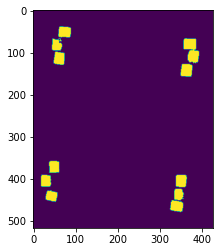

specim


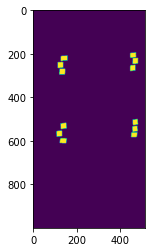

both


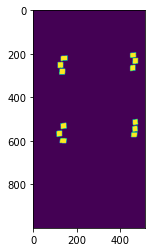

both


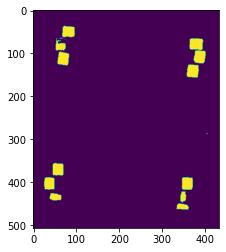

specim


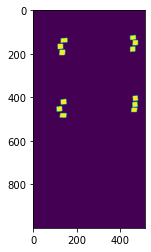

both


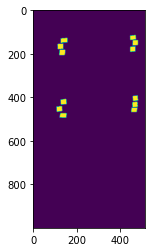

array([[ 1.06417035e+02, -6.96166958e+00, -4.74730128e+03],
       [ 1.43739435e+01,  1.40141841e+02, -1.53854851e+04],
       [-1.02565599e-02,  2.30913291e-02,  1.14611896e+02]])

In [406]:
matchImages(io.imread("D:/Ceramica/ImatgesTest/depth_color_test_1.png")[:,:,:-1],io.imread("D:/Ceramica/ImatgesTest/test_1.png"))
matchImages(io.imread("D:/Ceramica/ImatgesTest/depth_color_test_2.png")[:,:,:-1],io.imread("D:/Ceramica/ImatgesTest/test_2.png"))

#matchImages(io.imread("D:/Ceramica/ImatgesTest/g4_02_1A/depth_color_processed.png")[:,:,:-1],io.imread("D:/Ceramica/ImatgesTest/g2_02_1A/Im_calibration_pieces_2021-04-14_10-51-33.png"))

both


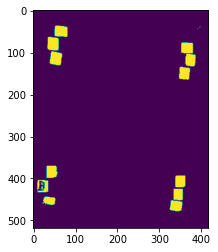

specim


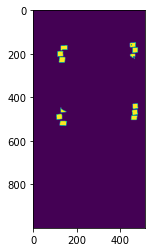

both


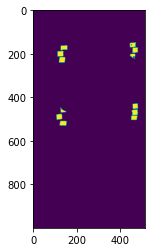

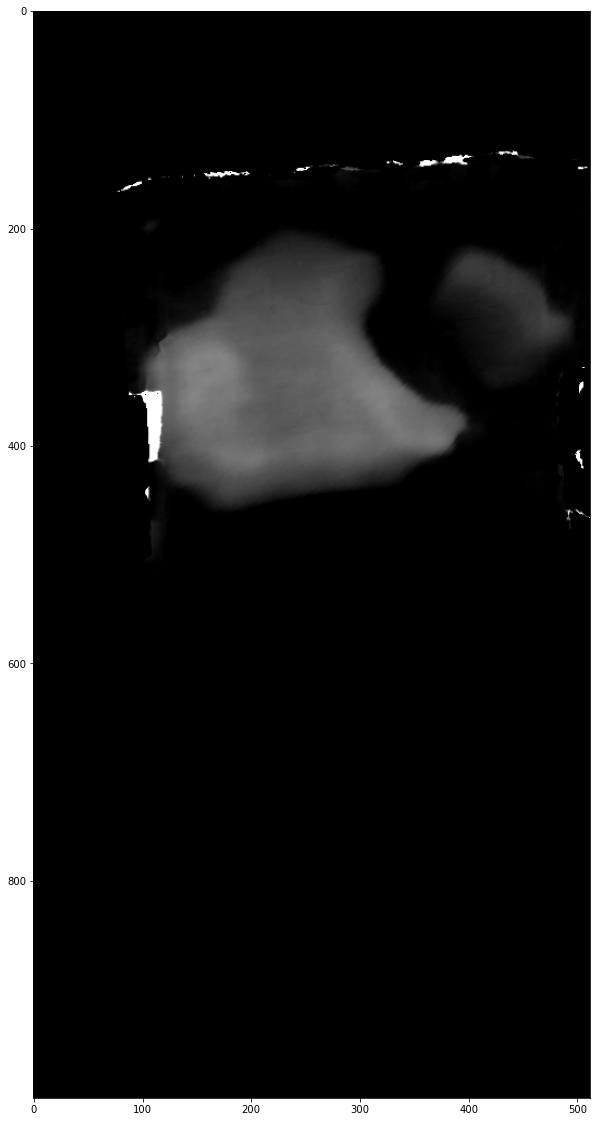

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [417]:
#matchDepthToSpecim(io.imread("D:/Ceramica/ImatgesTest/TestA/Im_calibration_pieces_2021-04-28_15-17-06.png"), io.imread("D:/Ceramica/ImatgesTest/TestA/depth_color_processed.png")[:,:,:-1], io.imread("D:/Ceramica/ImatgesTest/TestA/depth_processed.png")[:,:,:-1])
matchDepthToSpecim(io.imread("D:/Ceramica/ImatgesTest/TestB/Im_calibration_pieces_2021-04-28_15-20-44.png"), io.imread("D:/Ceramica/ImatgesTest/TestB/depth_color_processed.png")[:,:,:-1], io.imread("D:/Ceramica/ImatgesTest/TestB/depth_processed.png")[:,:,:-1])